In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import layers, losses
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')


2023-11-15 09:23:45.262932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-15 09:23:45.262948: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
test_name = '5_epochs_FL'#'descentralized_all_w_local_training_wo_global_data'
loss = 'mse'
model = 'All'
model_type = 'CNN'

datas = []
for i in ['train', 'evaluate_before_train', 'evaluate']:

    file = f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/{model_type}/{test_name}/{i}/loss_{loss}_{model}.csv'
    names = ['cid', 'round', 'loss','diff', 'anomaly', 'anomaly2']

    data = pd.read_csv(file,
                    names = names)
    
    datas.append(data)

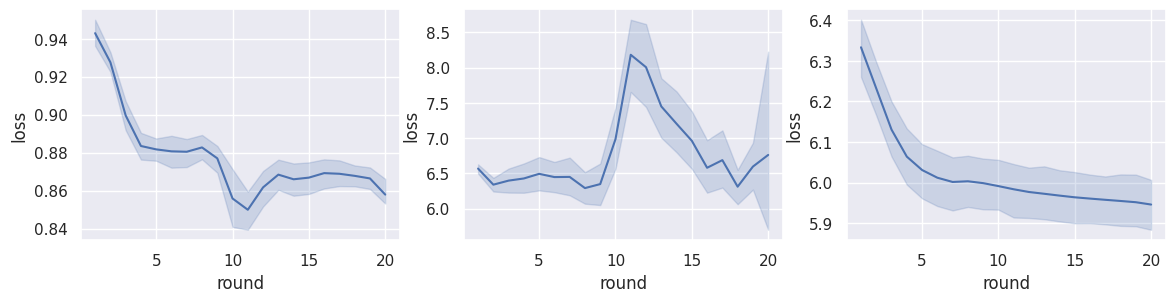

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    sns.lineplot(datas[i], x = 'round', y = 'loss', ax = axs[i])#, hue='cid', alpha = 0.3)

<AxesSubplot:xlabel='round', ylabel='loss'>

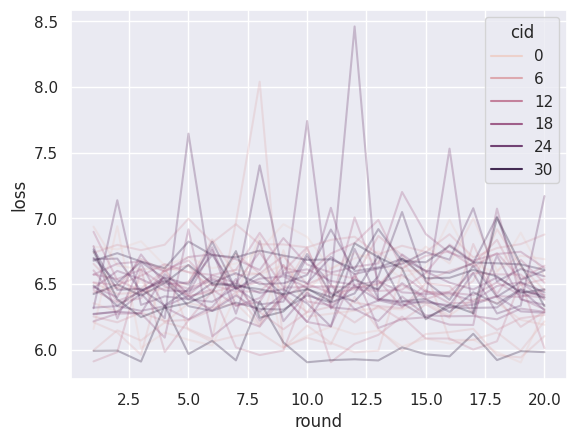

In [ ]:
sns.lineplot(datas[2], x = 'round', y = 'loss', hue='cid', alpha = 0.3)

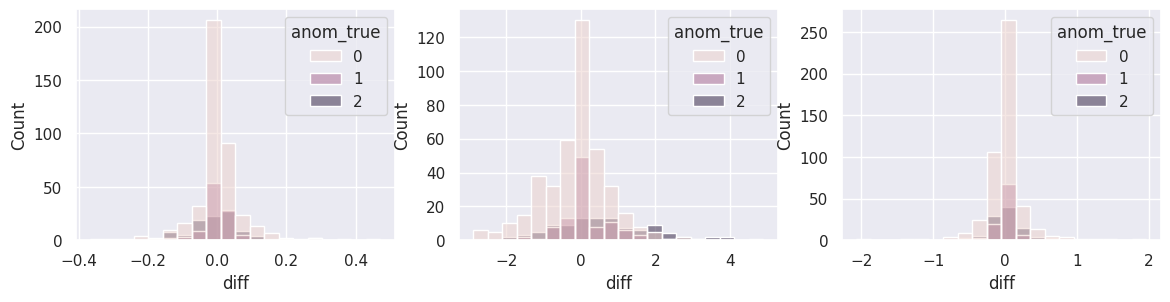

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    datas[i]['anom_true'] = datas[i]['round'].apply(lambda x: 1 if x==3 or x==4 or x==5 else (2 if x==12 or x==10 or x==11 else 0))
    sns.histplot(x = datas[i]['diff'], hue = datas[i]['anom_true'], bins = 20, ax = axs[i])

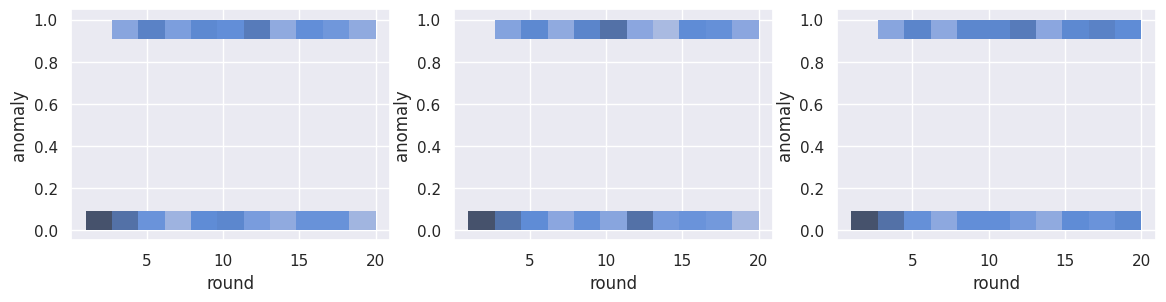

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    sns.histplot(x = datas[i]['round'], y = datas[i]['anomaly'], ax = axs[i])#, hue = data['anom_true'], bins = 20)

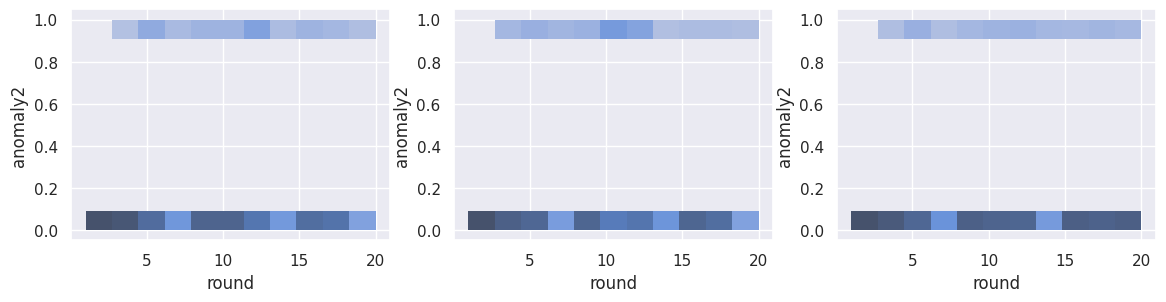

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    sns.histplot(x = datas[i]['round'], y = datas[i]['anomaly2'], ax = axs[i])#, hue = data['anom_true'], bins = 20)

In [ ]:
for i in range(3):

    data = datas[i]
    data['true_anomaly'] = data['round'].apply(lambda x: 1 if x>=9 else 0)

    data['anomaly12'] = data['anomaly'] + data['anomaly2'] 
    data['anomaly12'] = data['anomaly12'].apply(lambda x: 1 if x==2 else x)

    print('Anomaly1 ',f1_score(data['anomaly'], data['true_anomaly']),
        precision_score(data['anomaly'], data['true_anomaly']),
        recall_score(data['anomaly'], data['true_anomaly']),
        accuracy_score(data['anomaly'], data['true_anomaly']))

    print('Anomaly2 ',f1_score(data['anomaly2'], data['true_anomaly']),
        precision_score(data['anomaly2'], data['true_anomaly']),
        recall_score(data['anomaly2'], data['true_anomaly']),
        accuracy_score(data['anomaly2'], data['true_anomaly']))
    
    print('Anomaly12 ',f1_score(data['anomaly12'], data['true_anomaly']),
        precision_score(data['anomaly12'], data['true_anomaly']),
        recall_score(data['anomaly12'], data['true_anomaly']),
        accuracy_score(data['anomaly12'], data['true_anomaly']))
    
    print('-----------')



Anomaly1  0.6019108280254778 0.546242774566474 0.6702127659574468 0.5954692556634305
Anomaly2  0.30493273542600896 0.19653179190751446 0.68 0.49838187702265374
Anomaly12  0.6251944012441679 0.5809248554913294 0.6767676767676768 0.610032362459547
-----------
Anomaly1  0.5737704918032787 0.5057803468208093 0.6628787878787878 0.5792880258899676
Anomaly2  0.3157894736842105 0.20809248554913296 0.6545454545454545 0.49514563106796117
Anomaly12  0.6259780907668232 0.5780346820809249 0.6825938566552902 0.6132686084142395
-----------
Anomaly1  0.6185852981969487 0.5465686274509803 0.7124600638977636 0.5955882352941176
Anomaly2  0.24899598393574296 0.15196078431372548 0.6888888888888889 0.45
Anomaly12  0.6291208791208791 0.5612745098039216 0.715625 0.6029411764705882
-----------


In [ ]:
for i in range(3):

    df = datas[i].copy()
    df['anomaly'] = 0
    df['anomaly2'] = 0
    df['anomaly3'] = 0
    df['anomaly12'] = 0

    df['true_anomaly'] = df['round'].apply(lambda x: 1 if x>=9 else 0)

    th = 3

    for cid in range(34):
        for r in range(1, 20):

            if r>3:
                try:
                    diff = df[(df['cid'] == cid) & (df['round'] == r)]['diff'].values[0]

                    diff1 = df[(df['cid'] == cid) & (df['round'] == r-1)]['diff'].values[0]
                    diff2 = df[(df['cid'] == cid) & (df['round'] == r-2)]['diff'].values[0]
                    diff3 = df[(df['cid'] == cid) & (df['round'] == r-3)]['diff'].values[0]
                    mean_diff = np.mean([diff1, diff2, diff3])

                    anomaly = 0
                    if diff >= th*mean_diff: #se cresceu mais que o esperado, é a nomalia
                        anomaly = 1

                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly']= anomaly


                    diff = abs(df[(df['cid'] == cid) & (df['round'] == r)]['diff'].values[0])

                    diff1 = abs(df[(df['cid'] == cid) & (df['round'] == r-1)]['diff'].values[0])
                    diff2 = abs(df[(df['cid'] == cid) & (df['round'] == r-2)]['diff'].values[0])
                    diff3 = abs(df[(df['cid'] == cid) & (df['round'] == r-3)]['diff'].values[0])
                    mean_diff = np.mean([diff1, diff2, diff3])

                    anomaly3 = 0
                    if diff <= th*mean_diff: #se cresceu mais que o esperado, é a nomalia
                        anomaly3 = 1

                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly3']= anomaly3

                    anomaly2 = 0
                    loss =  df[(df['cid'] == cid) & (df['round'] == r)]['loss'].values[0]
                    last_losses1 = df[(df['cid'] == cid) & (df['round'] == r-1)]['loss'].values[0]
                    last_losses2 = df[(df['cid'] == cid) & (df['round'] == r-2)]['loss'].values[0]

                    if (loss - last_losses1) > 0:
                        if (last_losses1 - last_losses2) > 0:
                            anomaly2 = 1 
                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly2']= anomaly2

                except IndexError:
                    anomaly = df[df['cid'] == cid]['anomaly'].tail(1).values[0]

    df['anomaly12'] = df['anomaly'] + df['anomaly2'] 
    df['anomaly12'] = df['anomaly12'].apply(lambda x: 1 if x==2 else x)

    df['anomaly32'] = df['anomaly2'] + df['anomaly3'] 
    df['anomaly32'] = df['anomaly32'].apply(lambda x: 1 if x==2 else x)

    data = df.copy()
    print('Anomaly1 ',f1_score(df['anomaly'], data['true_anomaly']),
        precision_score(data['anomaly'], data['true_anomaly']),
        recall_score(data['anomaly'], data['true_anomaly']),
        accuracy_score(data['anomaly'], data['true_anomaly']))

    print('Anomaly2 ',f1_score(data['anomaly2'], data['true_anomaly']),
        precision_score(data['anomaly2'], data['true_anomaly']),
        recall_score(data['anomaly2'], data['true_anomaly']),
        accuracy_score(data['anomaly2'], data['true_anomaly']))
    
    print('Anomaly3 ',f1_score(data['anomaly3'], data['true_anomaly']),
        precision_score(data['anomaly3'], data['true_anomaly']),
        recall_score(data['anomaly3'], data['true_anomaly']),
        accuracy_score(data['anomaly3'], data['true_anomaly']))
    
    print('Anomaly12 ',f1_score(data['anomaly12'], data['true_anomaly']),
        precision_score(data['anomaly12'], data['true_anomaly']),
        recall_score(data['anomaly12'], data['true_anomaly']),
        accuracy_score(data['anomaly12'], data['true_anomaly']))
    
    print('Anomaly32 ',f1_score(data['anomaly32'], data['true_anomaly']),
        precision_score(data['anomaly32'], data['true_anomaly']),
        recall_score(data['anomaly32'], data['true_anomaly']),
        accuracy_score(data['anomaly32'], data['true_anomaly']))
    
    print('-----------')


Anomaly1  0.6016 0.5433526011560693 0.6738351254480287 0.5970873786407767
Anomaly2  0.30112359550561796 0.1936416184971098 0.6767676767676768 0.4967637540453074
Anomaly3  0.7957559681697614 0.8670520231213873 0.7352941176470589 0.7508090614886731
Anomaly12  0.6306027820710973 0.5895953757225434 0.6777408637873754 0.6132686084142395
Anomaly32  0.7989756722151088 0.9017341040462428 0.7172413793103448 0.7459546925566343
-----------
Anomaly1  0.5756578947368421 0.5057803468208093 0.6679389312977099 0.5825242718446602
Anomaly2  0.31208791208791214 0.20520231213872833 0.6513761467889908 0.4935275080906149
Anomaly3  0.8127490039840638 0.884393063583815 0.7518427518427518 0.7718446601941747
Anomaly12  0.637904468412943 0.5982658959537572 0.6831683168316832 0.6197411003236246
Anomaly32  0.8056265984654732 0.9104046242774566 0.7224770642201835 0.7540453074433657
-----------
Anomaly1  0.6056338028169014 0.5269607843137255 0.7119205298013245 0.5882352941176471
Anomaly2  0.2383838383838384 0.144607